In [1]:
import cv2
import numpy as np
import scanpy as sc
import anndata as ad
from matplotlib import pyplot as plt

In [4]:
def rotate_spatial_data(adata, angle=50, library_id=None):
    import numpy as np
    import cv2

    # 获取库ID
    if library_id is None:
        library_id = list(adata.uns['spatial'].keys())[0]  # 注意：原代码中可能拼写错误，应为 'spatial'
    
    # 提取空间信息
    spatial_info = adata.uns['spatial'][library_id]
    original_img = spatial_info['images']['hires']
    scalefactors = spatial_info['scalefactors']
    
    # 获取原始图像尺寸
    original_height, original_width = original_img.shape[:2]
    
    # 计算旋转后的新尺寸
    cos_angle = np.abs(np.cos(np.radians(angle)))
    sin_angle = np.abs(np.sin(np.radians(angle)))
    new_width = int((original_height * sin_angle) + (original_width * cos_angle))
    new_height = int((original_height * cos_angle) + (original_width * sin_angle))
    
    # 创建旋转矩阵
    rotation_matrix = cv2.getRotationMatrix2D(
        center=(original_width/2, original_height/2),
        angle=angle,
        scale=1.0
    )
    # 调整平移以适配新尺寸
    rotation_matrix[0, 2] += (new_width - original_width) / 2
    rotation_matrix[1, 2] += (new_height - original_height) / 2
    
    # 旋转图像（确保颜色通道为RGB）
    if original_img.shape[-1] == 3:  # 如果是RGB图像
        rotated_image = cv2.warpAffine(
            original_img,
            rotation_matrix,
            (new_width, new_height),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=(255, 255, 255)  # 修正：移除多余的右括号
        )
    else:  # 灰度图像
        rotated_image = cv2.warpAffine(
            original_img,
            rotation_matrix,
            (new_width, new_height),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=0
        )
    
    # 旋转空间坐标
    spatial_coords = adata.obsm['spatial'].copy()
    homogeneous_coords = np.hstack([spatial_coords, np.ones((len(spatial_coords), 1))])
    rotated_coords = (rotation_matrix @ homogeneous_coords.T).T
    
    # 创建新的AnnData对象（保持原始数据不变）
    rotated_adata = adata.copy()
    rotated_adata.obsm['spatial'] = rotated_coords
    
    # 更新空间信息
    rotated_adata.uns['spatial'][library_id]['images']['hires'] = rotated_image
    rotated_adata.uns['spatial'][library_id]['metadata']['rotation_angle'] = angle
    rotated_adata.uns['spatial'][library_id]['metadata']['original_dimensions'] = [original_width, original_height]
    
    return rotated_adata

In [21]:
# 加载数据
adata = ad.read_h5ad("./split_tissue_h5ad/e16_spatial.h5ad")

# 执行逆时针旋转
rotated_adata = rotate_spatial_data(adata, angle=60)

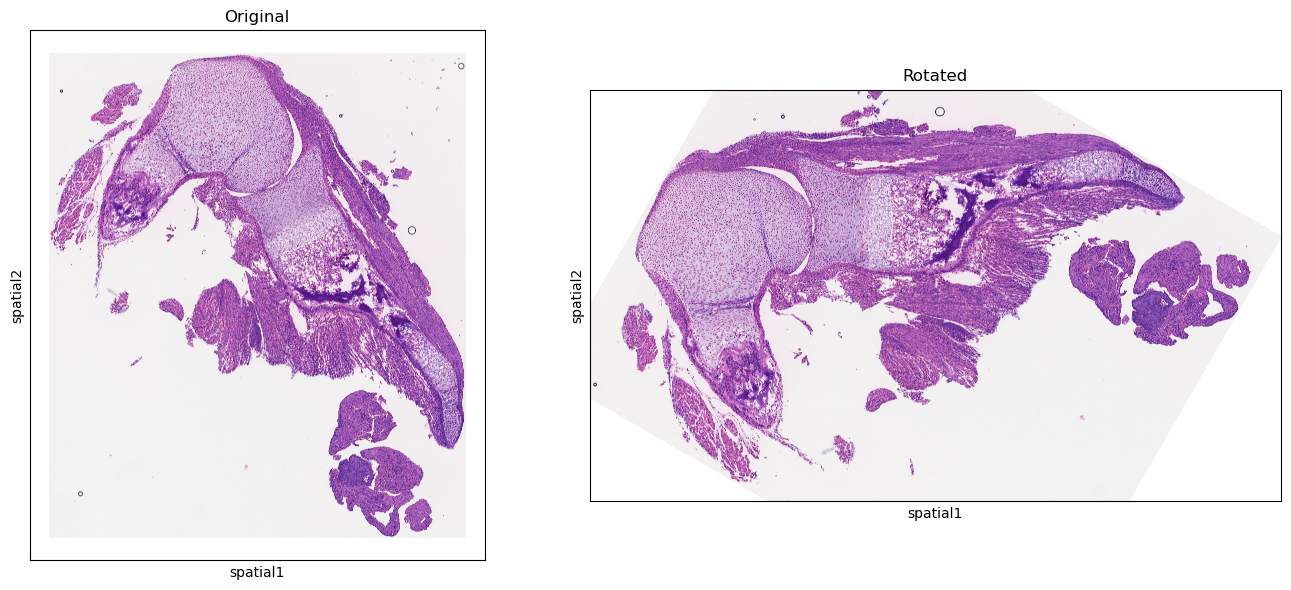

<Figure size 640x480 with 0 Axes>

In [22]:
# 可视化验证
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sc.pl.spatial(adata, ax=axes[0], show=False, title="Original")
sc.pl.spatial(rotated_adata, ax=axes[1], show=False, title="Rotated")
plt.tight_layout()
plt.show()
plt.savefig('./rotated_split_tissue_h5ad/e16.pdf')

In [23]:
# 保存结果
rotated_adata.write("./rotated_split_tissue_h5ad/rotated_e16_spatial.h5ad")